# Setup and Data Import

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

sys.path.insert(0,'..')
from src.data.make_dataset import read_main_df
from src.models.import_model import define_tpot_model
from src.models.model_selection import search_preprocessors

In [2]:
sns.set()

Firstly, we need to import dataset

In [3]:
# Path to dataframe
path_to_data = os.path.join('..', 'data', 'interim', 'prepared_data_Kamila.csv')

# reading dataframe
df = read_main_df(path_to_data,
                 drop_columns=['language'],
                 unstructured_columns=['tokens', 'entities', 'pos_tokens', 'tokens_lemma'])

In [4]:
df.head()

,artist_name,track_name,popularity,genre,lyrics,tokens,entities,pos_tokens,tokens_lemma
0,James Bay,Let It Go,73,rock,From walking home and talking loads To seeing ...,"[walking, home, talking, loads, seeing, shows,...","{'evening': 'TIME', 'Tryna': 'PERSON', 'Cause'...","[(walking, v), (home, n), (talking, v), (loads...","[walk, home, talk, load, see, show, even, clot..."
1,Bonobo,From You,67,jazz,Gone like changing seasons Alright alright You...,"[gone, like, changing, seasons, alright, alrig...",{},"[(gone, v), (like, n), (changing, v), (seasons...","[go, like, change, season, alright, alright, s..."
2,Lee Brice,One Of Them Girls,69,country,Are you one of them girls that peels off the B...,"[one, girls, peels, bud, light, label, might, ...","{'Kinda': 'PERSON', 'one': 'CARDINAL', 'all ni...","[(one, n), (girls, n), (peels, n), (bud, v), (...","[one, girl, peel, bud, light, label, might, ru..."
3,Andy Gibb,I Just Want To Be Your Everything,62,disco,For so long You and me been finding each other...,"[long, finding, long, feeling, feel, strong, g...",{'Build': 'FAC'},"[(long, r), (finding, v), (long, r), (feeling,...","[long, find, long, feel, feel, strong, girl, t..."
4,"Earth, Wind & Fire",You Want My Love,61,jazz,You ain t gotta say much I can tell that love ...,"[got, ta, say, much, tell, love, means, someth...","{'Don': 'PERSON', 'Lies': 'PERSON'}","[(got, v), (ta, n), (say, v), (much, r), (tell...","[get, ta, say, much, tell, love, mean, somethi..."


Lets divide data on train and test data set

In [5]:
# Splitting set to train and test sets
df_train, df_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'genre'], df['genre'],
                                                    random_state=7, stratify=df['genre'], test_size=0.2)

# Finding best preprocessor pipeline

## Define model

In previous experiment we find best model via tpot library. We defined function to import it.

In [6]:
# Defining model
model = define_tpot_model()

The experiment is to find the most optimal preprocess pipeline. In searching tpot model we used TfIdf. Now we inspect also Bag of words and different scaling method. Normally rules of thumbs say that text processed with these algorithm doesn't need to be scaled, but maybe we find an interesting observation. In previous experiment we also find that the result of model was positively correlated with the number of `max_features` in tfidf, so this time we evaluate model on `max_features` $\ge$ 300.

In [7]:
# Text columns used to experiment
text_columns = ['tokens_lemma', 'tokens']
# Tfidf param grid
tfidf_params = {'max_features': [300, 400, 500, 600, 700],
                'ngram_range': [(1, 3)],
                'use_idf': [True, False],
                'sublinear_tf': [True, False]}
# Count Vectorizer param grid
bow_params = {'max_features': [300, 400, 500, 600, 700],
              'ngram_range': [(1, 1), (1, 2), (1, 3)]}
# Possible scaling methods
scalers = [None, StandardScaler(), MinMaxScaler()]
# GridSearchCV additional arguments
cv_kwargs = {'cv': 10, 'n_jobs': -1, 'refit': 'f1_weighted'}
# Path to save result
path = os.path.join('..', 'data', 'external', 'best_preprocess_results.csv')

After defining param grids we run the experiment function

In [8]:
results = search_preprocessors(model, df_train, y_train, 
                    text_columns=text_columns,
                    tfidf_params=tfidf_params,
                    bow_params=bow_params,
                    scalers=scalers,
                    cv_kwargs=cv_kwargs,
                    random_state=7,
                    verbose=1,
                    path=path)

Iteration 0/12
Iteration 1/12. Time:  92.59 min
Iteration 2/12. Time:  92.94 min
Iteration 3/12. Time:  92.41 min
Iteration 4/12. Time:  52.41 min
Iteration 5/12. Time:  52.57 min
Iteration 6/12. Time:  53.03 min
Iteration 7/12. Time:  90.89 min
Iteration 8/12. Time:  92.36 min
Iteration 9/12. Time:  90.43 min
Iteration 10/12. Time:  52.40 min
Iteration 11/12. Time:  52.84 min
Iteration 12/12. Time:  53.33 min


In [9]:
results.head()

,On Column,Preprocessor,Scaler,Params,Accuracy,Recall,Precision,F1
0,tokens_lemma,TfidfVectorizer,NoneType,"{'preprocessor__max_features': 300, 'preproces...",0.42,0.42,0.41,0.41
1,tokens_lemma,TfidfVectorizer,NoneType,"{'preprocessor__max_features': 300, 'preproces...",0.42,0.42,0.41,0.40
2,tokens_lemma,TfidfVectorizer,NoneType,"{'preprocessor__max_features': 300, 'preproces...",0.42,0.42,0.40,0.40
3,tokens_lemma,TfidfVectorizer,NoneType,"{'preprocessor__max_features': 300, 'preproces...",0.42,0.42,0.41,0.41
4,tokens_lemma,TfidfVectorizer,NoneType,"{'preprocessor__max_features': 400, 'preproces...",0.43,0.43,0.42,0.42


# Result visualization

Lets check the best preprocessor and its results

In [10]:
# Finding preprocessor which had the max F1 score
idxmax = results['F1'].idxmax()
results.loc[idxmax:idxmax, :]

,On Column,Preprocessor,Scaler,Params,Accuracy,Recall,Precision,F1
16,tokens_lemma,TfidfVectorizer,NoneType,"{'preprocessor__max_features': 700, 'preproces...",0.46,0.46,0.45,0.45


In [13]:
results.loc[idxmax, 'Params']

{'preprocessor__max_features': 700,
 'preprocessor__ngram_range': (1, 3),
 'preprocessor__sublinear_tf': True,
 'preprocessor__use_idf': True}

In [11]:
# Unpacking max_features params from dict of params 
results['max_features'] = results['Params'].apply(lambda x: x['preprocessor__max_features'])

# We want to visualize solutions on pointplots
# For simplify lets define function
def make_pointplot(hue: str, ax):
    """
    Function draw pointplot on given axis and split data on hue column
    
    Args:
        hue: name of column with categorical variable to split them on plot
        ax: matplotlib axes object
    """
    sns.pointplot(x='max_features',
              y='F1',
              data=results,
              hue=hue, ax=ax)


We can visualize results with respect to different:
- preprocessors
- scalers
- token type column

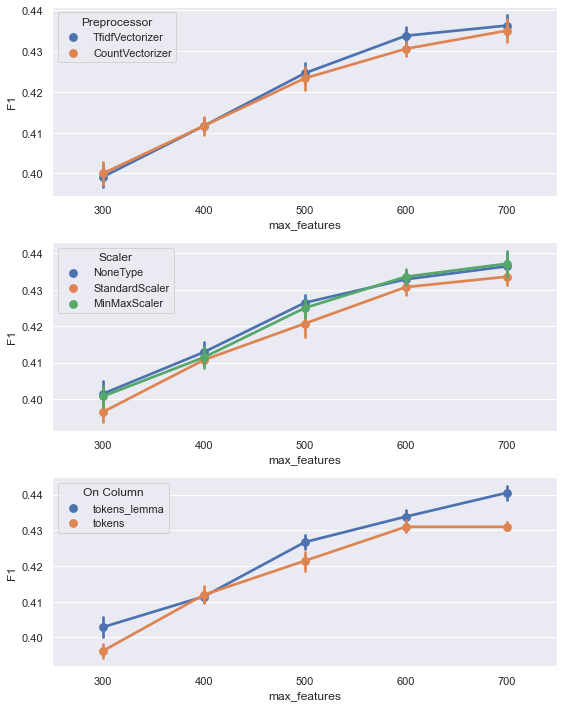

In [12]:
# Defining canvas
fig, ax = plt.subplots(3, 1, figsize=(8, 10))

# Drawing pointplots
make_pointplot('Preprocessor', ax[0])
make_pointplot('Scaler', ax[1])
make_pointplot('On Column', ax[2])

# Tighting layout for better estetic
plt.tight_layout()
# Display
plt.show()

# Evaluation on test set

Lets evaluate our pipeline on test set

In [16]:
# Processing input data
X_train = df_train.copy()['tokens_lemma'].apply(lambda x: ' '.join(x))
X_test = df_test.copy()['tokens_lemma'].apply(lambda x: ' '.join(x))

# Encoding output data
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)


tfidf_kwargs = {'max_features': 700,
                 'ngram_range': (1, 3),
                 'sublinear_tf': True,
                 'use_idf': True}

# Defining best preprocessor pipeline
pipeline = Pipeline([('preprocessor', TfidfVectorizer(**tfidf_kwargs)),
                     ('to_dense', FunctionTransformer(lambda x: x.toarray())),
                     ('scaler', MinMaxScaler()),
                     ('model', model)])

# Training pipeline
pipeline.fit(X_train, y_train_le);

In [17]:
# Evaluating on test set
preds = pipeline.predict(X_test)
print(classification_report(y_test_le, preds))

              precision    recall  f1-score   support

           0       0.30      0.33      0.32       141
           1       0.61      0.70      0.65       167
           2       0.49      0.50      0.50       141
           3       0.64      0.77      0.70       152
           4       0.51      0.46      0.48       105
           5       0.39      0.33      0.35       143
           6       0.41      0.50      0.45       169
           7       0.36      0.16      0.22       100
           8       0.00      0.00      0.00         6
           9       0.22      0.20      0.21       133

    accuracy                           0.46      1257
   macro avg       0.39      0.39      0.39      1257
weighted avg       0.44      0.46      0.44      1257



We can check how the pipeline will perform without the least frequent class which is reggae. We can see that accuracy increased a bit and macro accuracy increased substantially.

In [29]:
idx_tr = y_train[y_train != 'reggae'].index
idx_test = y_test[y_test != 'reggae'].index

In [31]:
# Processing input data
X_train = df_train.loc[idx_tr, :].copy()['tokens_lemma'].apply(lambda x: ' '.join(x))
X_test = df_test.loc[idx_test, :].copy()['tokens_lemma'].apply(lambda x: ' '.join(x))

# Encoding output data
le = LabelEncoder()
y_train_le = le.fit_transform(y_train.loc[idx_tr])
y_test_le = le.transform(y_test.loc[idx_test])


tfidf_kwargs = {'max_features': 700,
                 'ngram_range': (1, 3),
                 'sublinear_tf': True,
                 'use_idf': True}

# Defining best preprocessor pipeline
pipeline = Pipeline([('preprocessor', TfidfVectorizer(**tfidf_kwargs)),
                     ('to_dense', FunctionTransformer(lambda x: x.toarray())),
                     ('scaler', MinMaxScaler()),
                     ('model', model)])

# Training pipeline
pipeline.fit(X_train, y_train_le);

In [32]:
# Evaluating on test set
preds = pipeline.predict(X_test)
print(classification_report(y_test_le, preds))

              precision    recall  f1-score   support

           0       0.34      0.37      0.35       141
           1       0.66      0.71      0.68       167
           2       0.51      0.52      0.51       141
           3       0.63      0.76      0.69       152
           4       0.48      0.47      0.47       105
           5       0.37      0.30      0.33       143
           6       0.42      0.51      0.46       169
           7       0.34      0.14      0.20       100
           8       0.24      0.23      0.24       133

    accuracy                           0.47      1251
   macro avg       0.44      0.45      0.44      1251
weighted avg       0.45      0.47      0.45      1251

